In [1]:
import xarray
import matplotlib.pyplot as plt
import numpy as np
import pandas
from pyproj import CRS, Transformer

# Finden Hauptwindrichtung

<AxesSubplot:xlabel='time'>

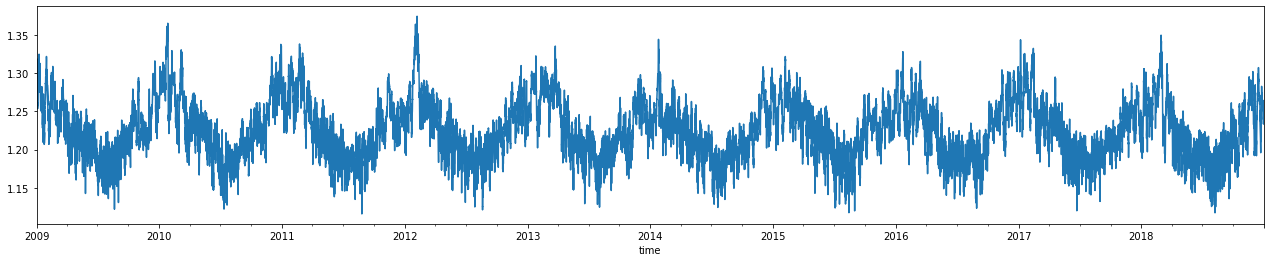

In [13]:
data_path = f"/uba/anemos_winddata/20191029_anemosDataFull/UBA-Windatlas/TSNC-Format/rho*"

data = xarray.open_mfdataset(data_path, engine='h5netcdf', parallel=True)

rho = data.interp(x= x, y= y, level=level, method= "linear")
rho.rho.to_pandas().plot(figsize=(22,4))

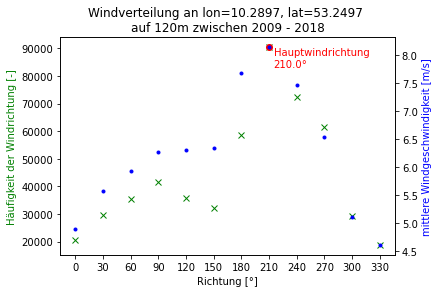

<xarray.Dataset>
Dimensions:         (x: 225, y: 310, klassen: 12)
Coordinates:
  * x               (x) int16 0 1 2 3 4 5 6 7 ... 218 219 220 221 222 223 224
  * y               (y) int16 0 1 2 3 4 5 6 7 ... 303 304 305 306 307 308 309
Dimensions without coordinates: klassen
Data variables:
    lon             (y, x) float64 ...
    lat             (y, x) float64 ...
    wspd            (klassen, y, x) float64 ...
    wspd_sdev       (klassen, y, x) float64 ...
    histo           (klassen, y, x) int32 ...
    klassengrenzen  (klassen) float64 ...
    wbk             (klassen, y, x) float64 ...
    wbA             (klassen, y, x) float64 ...
Attributes:
    Referenzperiode:  2009 - 2018

In [3]:
level = 120
x = 113.11
y= 223.27

data_path = f"/uba/anemos_winddata/20191029_anemosDataFull/UBA-Windatlas/Statistics/10-Jahresmittel/dirhistos.{level}m.2009-2018.nc"

data = xarray.open_dataset(data_path, engine='h5netcdf')
test = data.interp(x= x, y= y, method= "quadratic")

wspd = test.wspd.values
histo = test.histo.values
direct = test.klassengrenzen.values - test.klassengrenzen.values[1]
hauptwindID = np.argmax(histo)

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(direct, histo, marker="x", linestyle="", color='g')
ax1.plot(direct[hauptwindID], histo[hauptwindID], marker="o", linestyle="", color='r')
ax1.text(direct[hauptwindID] +5, histo[hauptwindID],s=f"Hauptwindrichtung \n{str(direct[hauptwindID])}°", color="r", verticalalignment='top')

ax2.plot(direct, wspd, marker=".", linestyle="", color="b")

ax1.set_title(f"Windverteilung an lon={np.around(test.lon.values,4)}, lat={np.around(test.lat.values,4)} \nauf {level}m zwischen {test.attrs.get('Referenzperiode')}")
ax1.set_xlabel('Richtung [°]')
ax1.set_ylabel('Häufigkeit der Windrichtung [-]', color='g')
ax2.set_ylabel('mittlere Windgeschwindigkeit [m/s]', color='b')
ax1.set_xticks(direct)

plt.show()
fig.savefig("Hauptwindrichtung.eps", format='eps')
data

In [4]:
data_path = f"/uba/anemos_winddata/20191029_anemosDataFull/UBA-Windatlas/Statistics/10-Jahresmittel/wspd.10L.ltm.2009-2018.nc"

data = xarray.open_dataset(data_path, engine='h5netcdf')
data

<xarray.Dataset>
Dimensions:  (y: 310, x: 225, time: 1, level: 10)
Coordinates:
    lat      (y, x) float32 ...
    lon      (y, x) float32 ...
  * time     (time) datetime64[ns] 2013-12-31T23:55:00
  * x        (x) int16 0 1 2 3 4 5 6 7 8 ... 216 217 218 219 220 221 222 223 224
  * y        (y) int16 0 1 2 3 4 5 6 7 8 ... 301 302 303 304 305 306 307 308 309
  * level    (level) float32 40.0 60.0 80.0 100.0 ... 170.0 200.0 250.0 300.0
Data variables:
    wspd     (time, level, y, x) float32 ...
Attributes: (12/130)
    TITLE:                           D3E5
    START_DATE:                      2003-12-27_00:00:00
    SIMULATION_START_DATE:           2003-12-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        [256]
    SOUTH-NORTH_GRID_DIMENSION:      [352]
    BOTTOM-TOP_GRID_DIMENSION:       [50]
    ...                              ...
    ISOILWATER:                      [14]
    history:                         Wed Aug  7 19:02:24 2019: ncrcat -7 -L 3...
    NCO:                             4.4.2
    title:                           D3E5
    nco_openmp_thread_number:        [1]
    actual_range:                    [100. 100.]

In [46]:
xy_path = r"xy_lamber_projection_values"

new_dim_coor = pandas.read_csv(xy_path)
# assign the new x,y values to the netCDF data
x = new_dim_coor["x"].dropna().astype("int").values
y = new_dim_coor["y"].values


__lambert_proj_str = "+proj=lcc +lat_1=48.0 +lat_2=54.0 +lat_0=50.893 +lon_0=10.736 +a=6370000 +b=6370000 +nadgrids=null +no_defs"

crsD3E5 = CRS.from_proj4(__lambert_proj_str)
crsGeo = CRS.from_epsg(4326)
geo2altas = Transformer.from_crs(crsD3E5, crsGeo)

dummy = np.array([y[0]]*len(x))

x_new,y_new = geo2altas.transform(xx=x[0], yy=dummy[0])


data.assign_coords(
            coords={"x": x_new,"y": y_new}
            )

ValueError: dimension 'y' already exists as a scalar variable

In [44]:
len(dummy)

225